In [3]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [2]:
#!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
#import segmentation_models_pytorch as smp

In [4]:
#Image data can be downloaded from https://www.kaggle.com/datasets/residentmario/segmented-bob-ross-images
#Download the zip file to the working directory and unzip the file. 
#!unzip BobRossPaintings.zip

Archive:  BobRossPaintings.zip
  inflating: labels.csv              
  inflating: train/images/painting10.png  
  inflating: train/images/painting101.png  
  inflating: train/images/painting103.png  
  inflating: train/images/painting105.png  
  inflating: train/images/painting109.png  
  inflating: train/images/painting110.png  
  inflating: train/images/painting111.png  
  inflating: train/images/painting112.png  
  inflating: train/images/painting115.png  
  inflating: train/images/painting116.png  
  inflating: train/images/painting117.png  
  inflating: train/images/painting118.png  
  inflating: train/images/painting12.png  
  inflating: train/images/painting120.png  
  inflating: train/images/painting121.png  
  inflating: train/images/painting123.png  
  inflating: train/images/painting124.png  
  inflating: train/images/painting125.png  
  inflating: train/images/painting128.png  
  inflating: train/images/painting129.png  
  inflating: train/images/painting13.png  
  inflatin

In [5]:
DATA_DIR = './segmented-bob-ross-images'

images_dir = os.path.join(DATA_DIR, 'train', 'images')
masks_dir = os.path.join(DATA_DIR, 'train', 'labels')

image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

paths_df = pd.DataFrame()
paths_df['image_path'] = image_paths
paths_df['mask_path'] = mask_paths

# Shuffle DataFrame
paths_df = paths_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = paths_df.sample(frac=0.1, random_state=42)
train_df = paths_df.drop(valid_df.index)
len(train_df), len(valid_df)

(225, 25)

In [7]:
labels_df = pd.read_csv("./segmented-bob-ross-images/labels.csv")
# Get class names
class_names = labels_df['class'].tolist()
# Get class IDs
class_ids = labels_df['Id'].tolist()

print('All dataset class names and their corresponding IDs in labels:')
print('Class Names: ', class_names)
print('Class IDs: ', class_ids)

All dataset class names and their corresponding IDs in labels:
Class Names:  ['sky', 'tree', 'grass', 'earth;rock', 'mountain;mount', 'plant;flora;plant;life', 'water', 'sea', 'river']
Class IDs:  [3, 5, 10, 14, 17, 18, 22, 27, 61]


In [8]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['sky', 'tree', 'grass', 'earth;rock', 'mountain;mount', 'plant;flora;plant;life', 'water', 'sea', 'river']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_ids =  np.array(class_ids)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', select_classes)
print('Class IDs: ', select_class_ids)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['sky', 'tree', 'grass', 'earth;rock', 'mountain;mount', 'plant;flora;plant;life', 'water', 'sea', 'river']
Class IDs:  [ 3  5 10 14 17 18 22 27 61]


In [9]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [10]:
class PaintingsDataset(torch.utils.data.Dataset):

    """Bob Ross Paintings Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (str): DataFrame containing images / labels paths
        class_ids (list): class IDs of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            df,
            class_ids=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        
        self.class_ids = class_ids
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_ids).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

Visualize sample image and mask

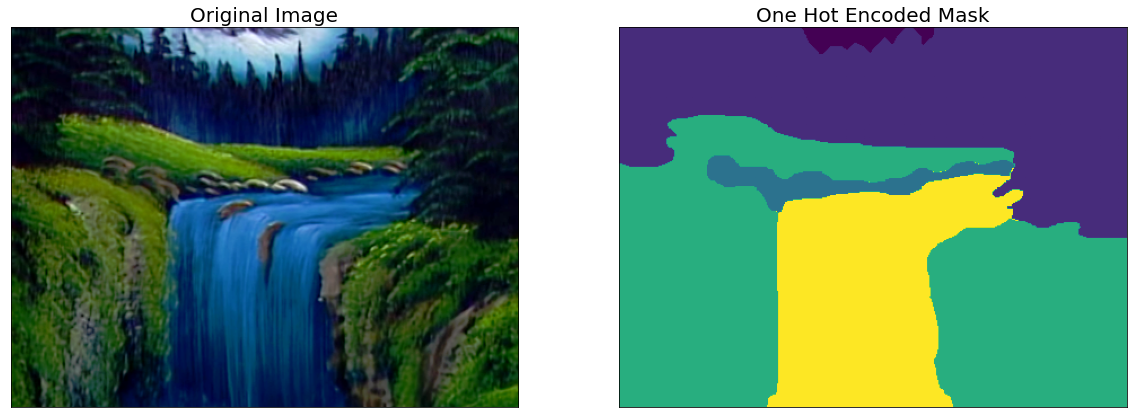

In [11]:
dataset = PaintingsDataset(train_df, class_ids=select_class_ids)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    one_hot_encoded_mask = reverse_one_hot(mask)
)

Defining Training and Validation Augmentations

In [13]:
def get_training_augmentation():
    train_transform = [
        # album.PadIfNeeded(min_height=896, min_width=576, always_apply=True, border_mode=0),
        album.ShiftScaleRotate(scale_limit=0.16, rotate_limit=30, shift_limit=0.16, p=0.8, border_mode=0),
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
            ],
            p=0.5,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=352, min_width=480, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)


Visualize Augmented Images & Masks

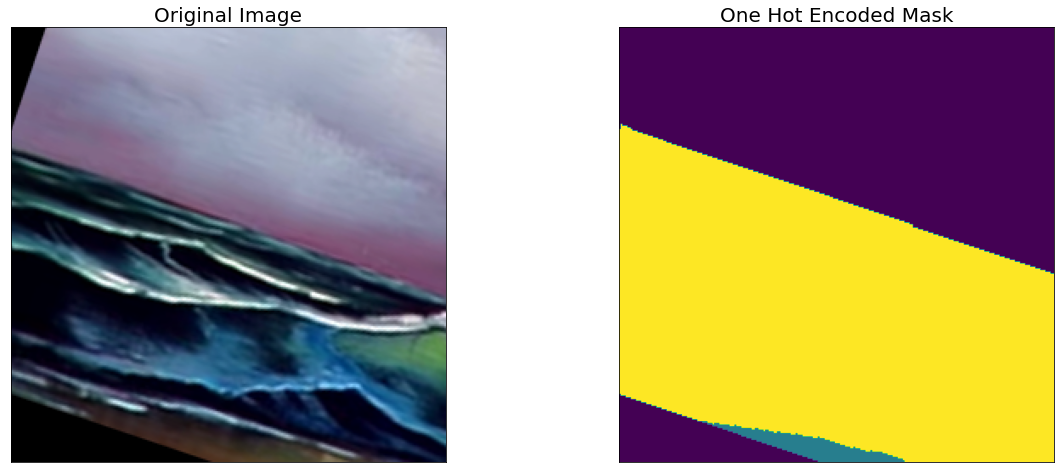

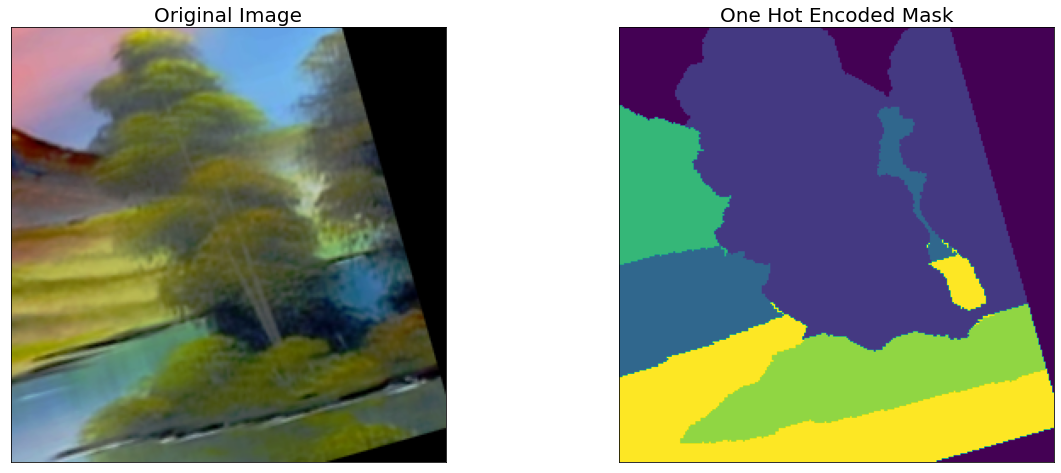

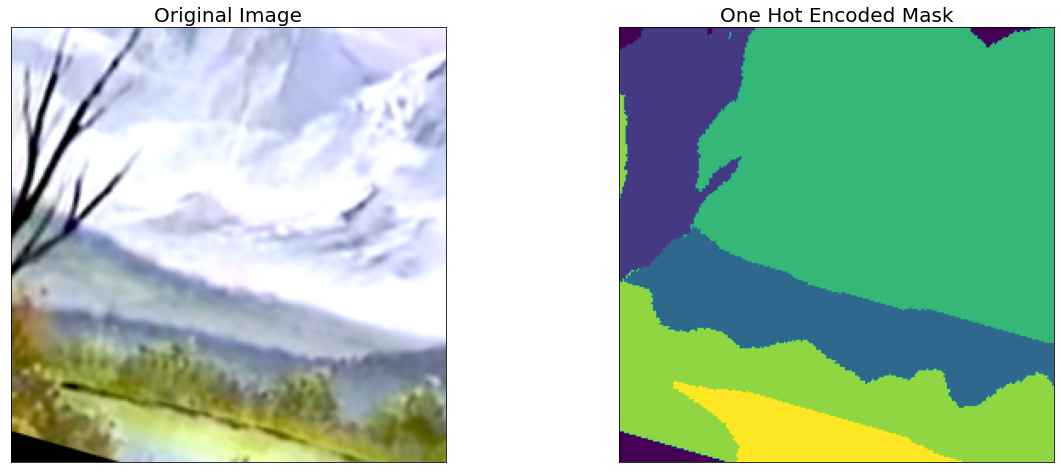

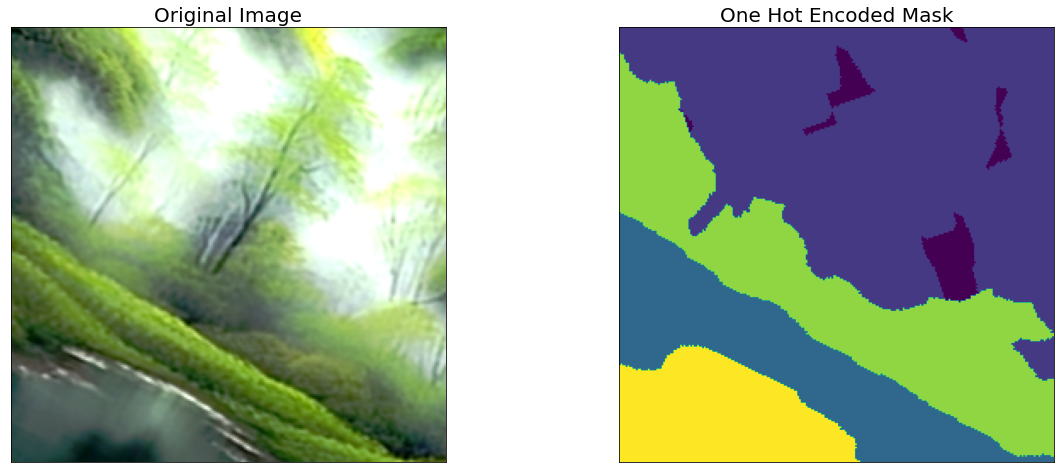

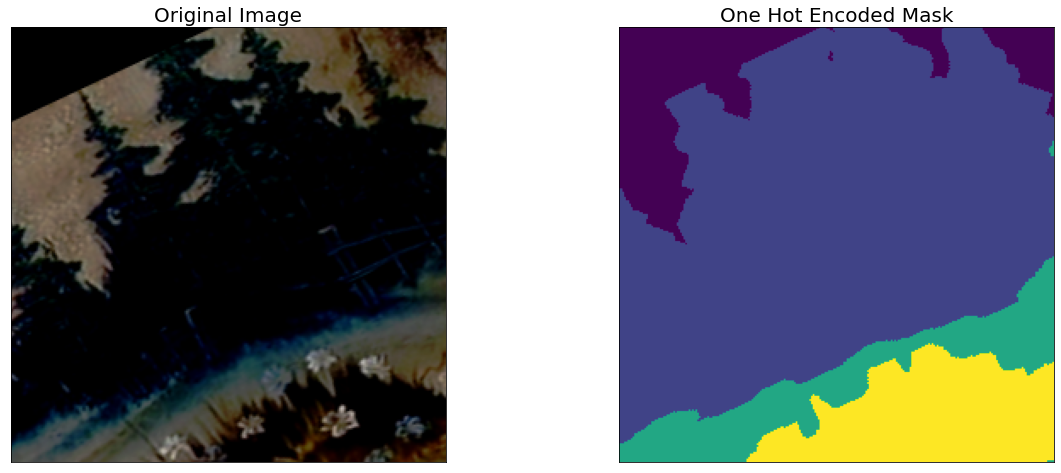

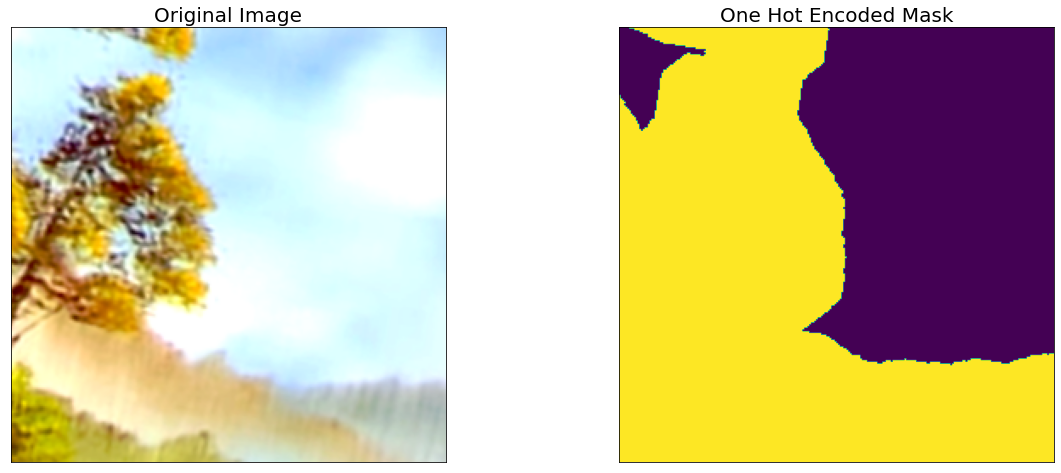

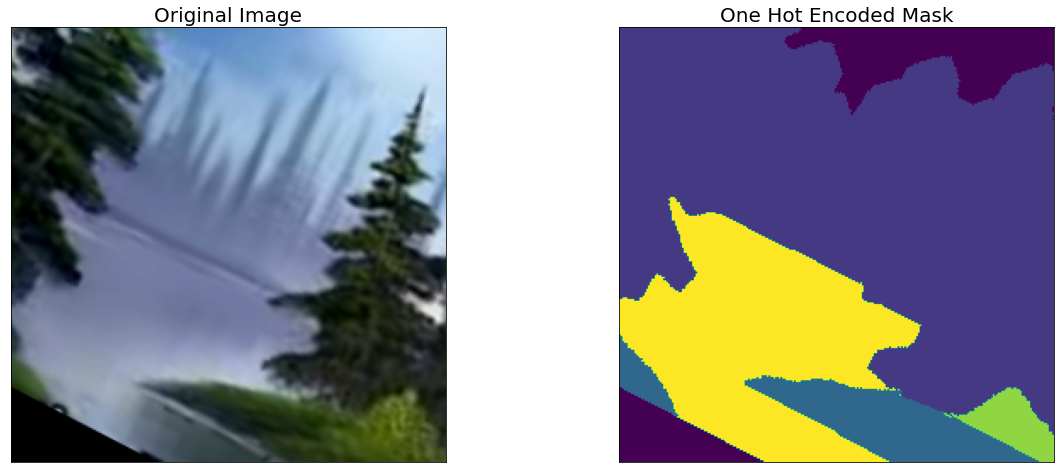

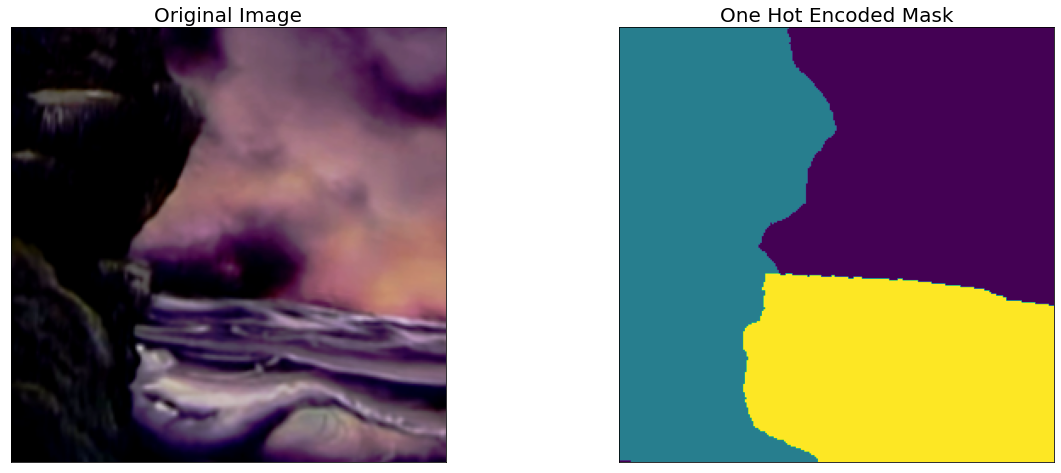

In [14]:
augmented_dataset = PaintingsDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    class_ids=select_class_ids,
)

# Different augmentations on image/mask pairs
for idx in range(8):
    random_idx = random.randint(0, len(augmented_dataset)-1)
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

Training UNet

In [15]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [16]:
# Get train and val dataset instances
train_dataset = PaintingsDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_ids=select_class_ids,
)

valid_dataset = PaintingsDataset(
    valid_df, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_ids=select_class_ids,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4)

Set Hyperparameters

In [17]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 8

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unet-for-segmenting-bob-ross-paintings-pytorch/best_model.pth'):
    model = torch.load('../input/unet-for-segmenting-bob-ross-paintings-pytorch/best_model.pth', map_location=DEVICE)
    print("Loaded UNet model from a previous commit.")

In [18]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

Training UNet

In [82]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, 20):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 4/4 [00:12<00:00,  3.13s/it, dice_loss - 0.5524, iou_score - 0.4924]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:12<00:00,  3.20s/it, dice_loss - 0.5363, iou_score - 0.5192]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:11<00:00,  2.86s/it, dice_loss - 0.5303, iou_score - 0.5388]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:11<00:00,  2.90s/it, dice_loss - 0.518, iou_score - 0.5558] 
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:11<00:00,  2.91s/it, dice_loss - 0.5091, iou_score - 0.5539]

Epoch: 5
valid: 100%|██████████| 4/4 [00:11<00:00,  2.85s/it, dice_loss - 0.503, iou_score - 0.561]  
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:11<00:00,  2.90s/it, dice_loss - 0.4933, iou_score - 0.5567]

Epoch: 7
valid: 100%|██████████| 4/4 [00:11<00:00,  2.95s/it, dice_loss - 0.4839, iou_score - 0.5694]
Model saved!

Epoch: 8
valid: 100%|██████████| 4/4 [00:11<00:00,  2.90s/it, dice_loss - 0.4744, iou_score - 0.5

Prediction on Test Data

In [83]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/unet-for-segmenting-bob-ross-paintings-pytorch/best_model.pth'):
    best_model = torch.load('../input/unet-for-segmenting-bob-ross-paintings-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


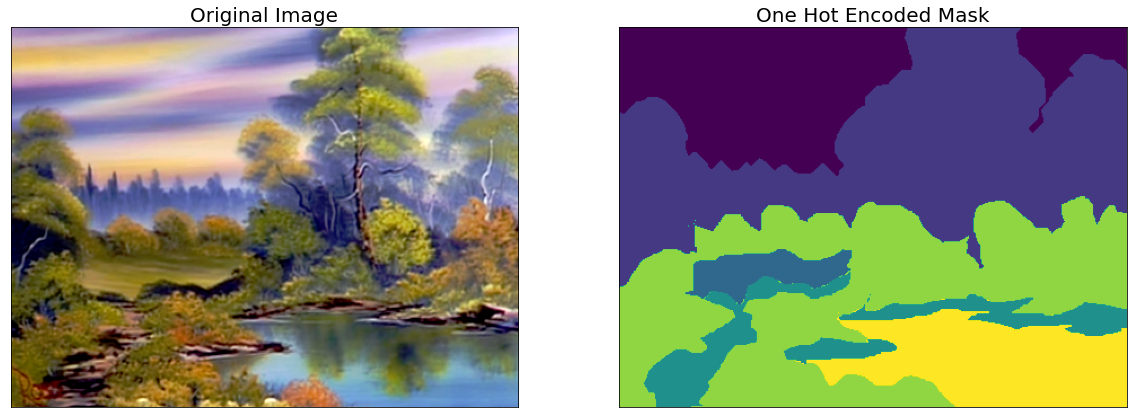

In [87]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = PaintingsDataset(
    valid_df, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_ids=select_class_ids,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = PaintingsDataset(
    valid_df,
    class_ids=select_class_ids,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [88]:
# Center crop padded image / mask to original image dims
def crop_image(image, true_dimensions):
    return album.CenterCrop(p=1, height=true_dimensions[0], width=true_dimensions[1])(image=image)

In [89]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

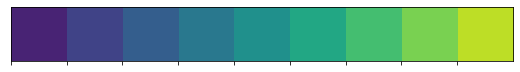

In [90]:
color_palette = (np.array(sns.color_palette("viridis", len(select_classes)))*255).astype(int)
sns.palplot(sns.color_palette("viridis", len(select_classes)))

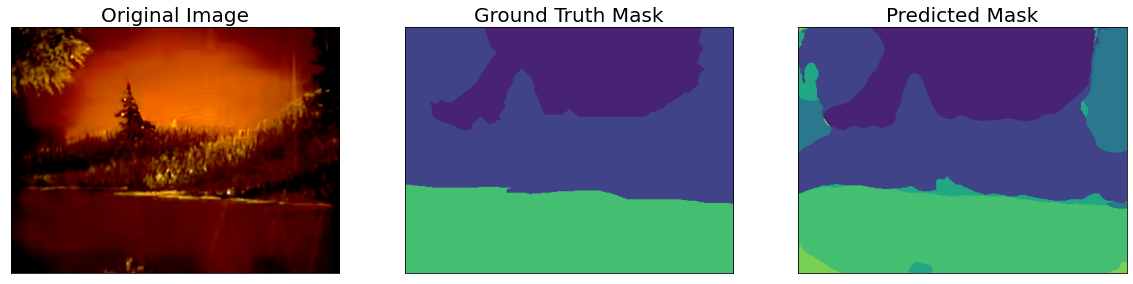

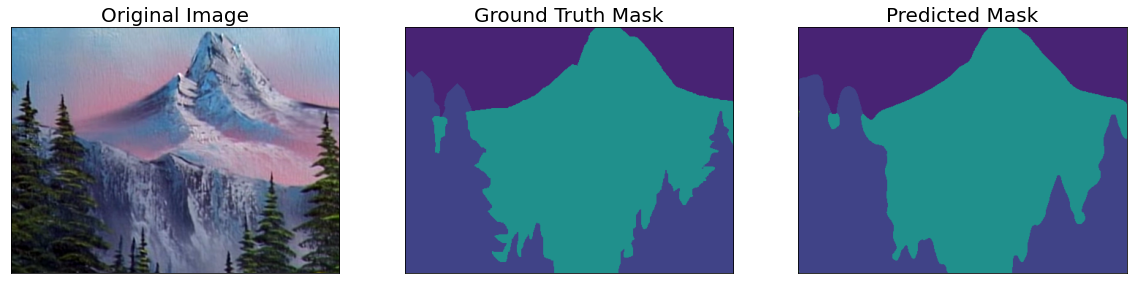

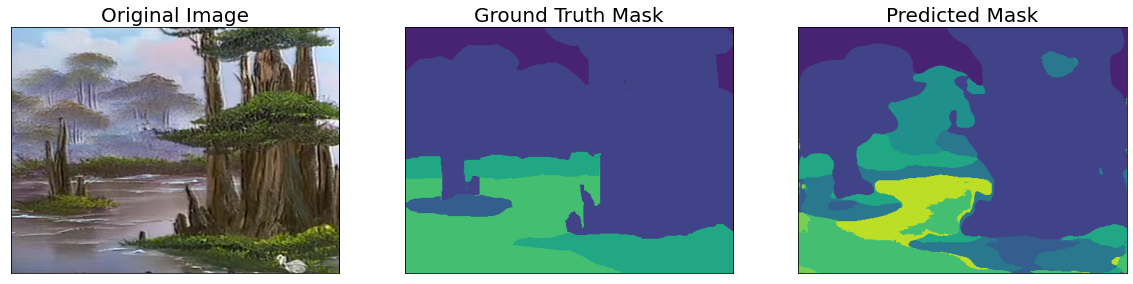

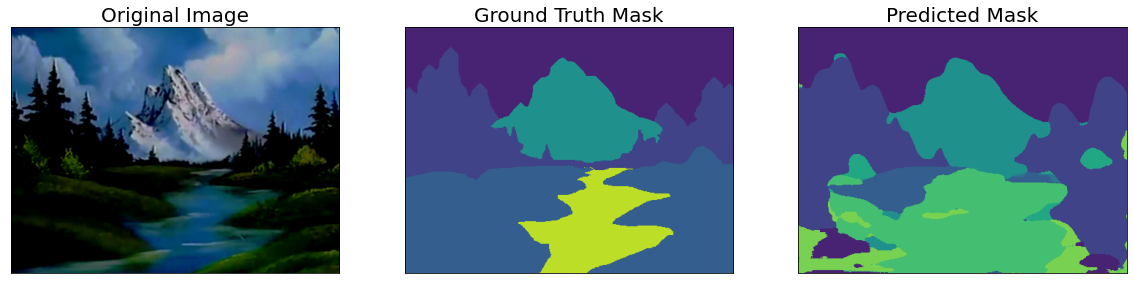

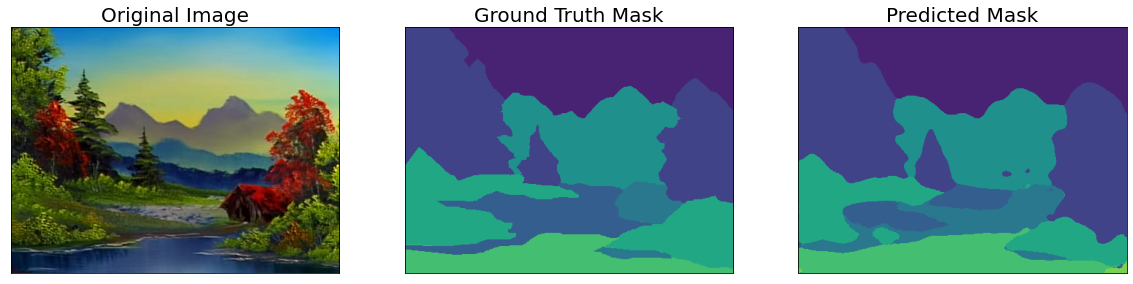

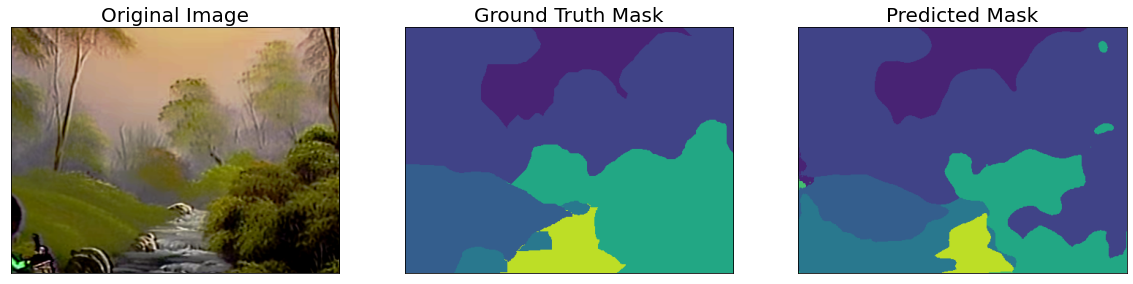

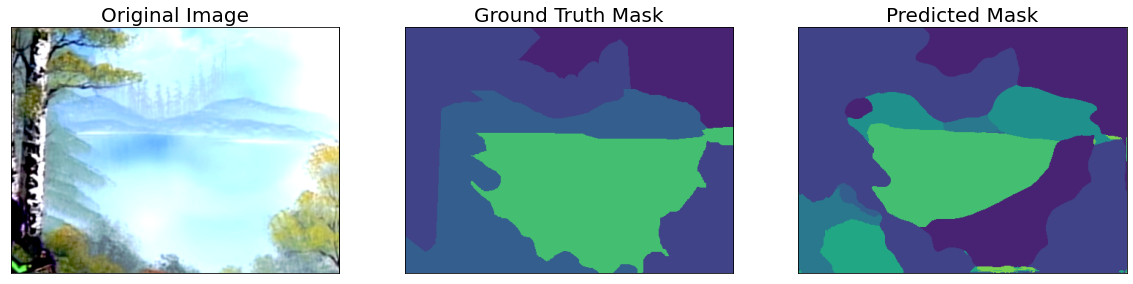

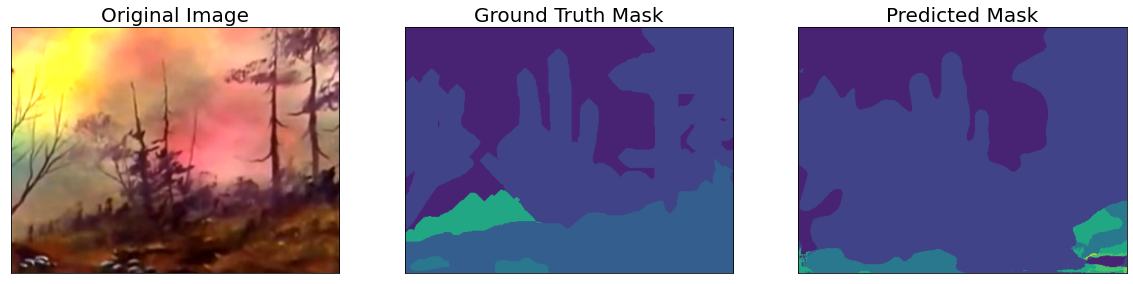

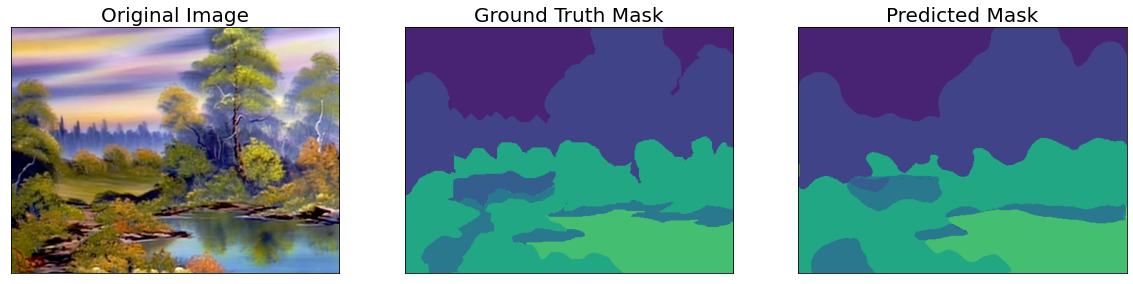

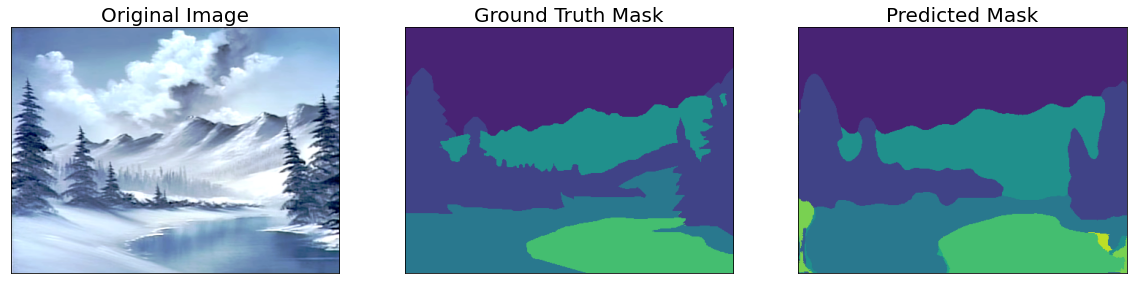

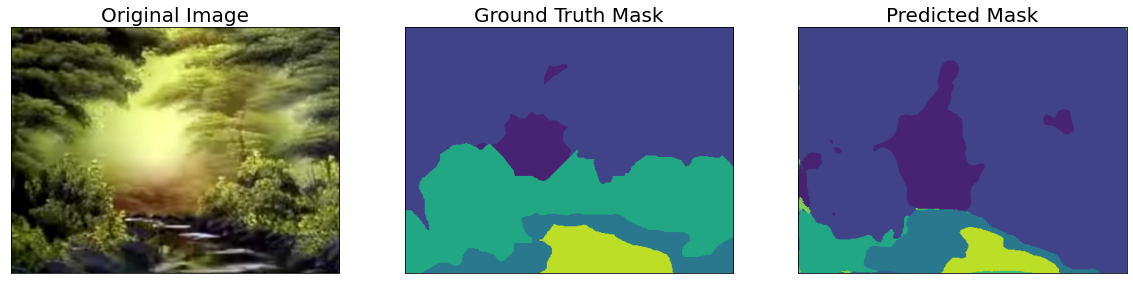

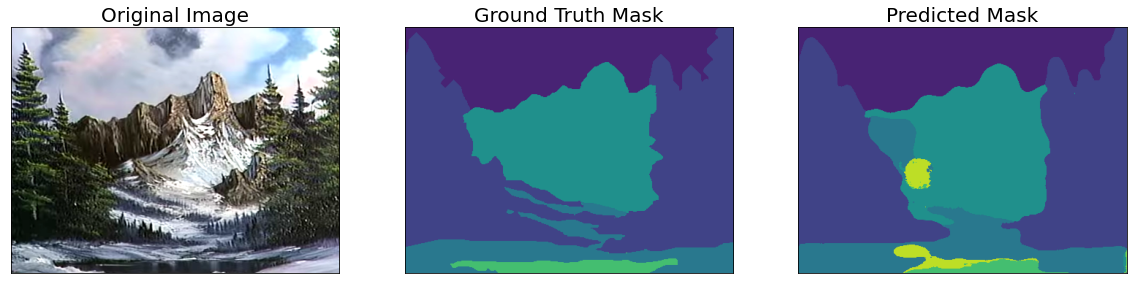

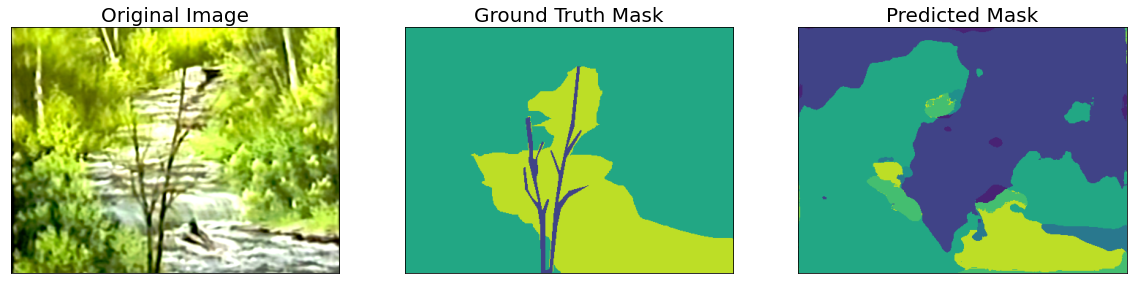

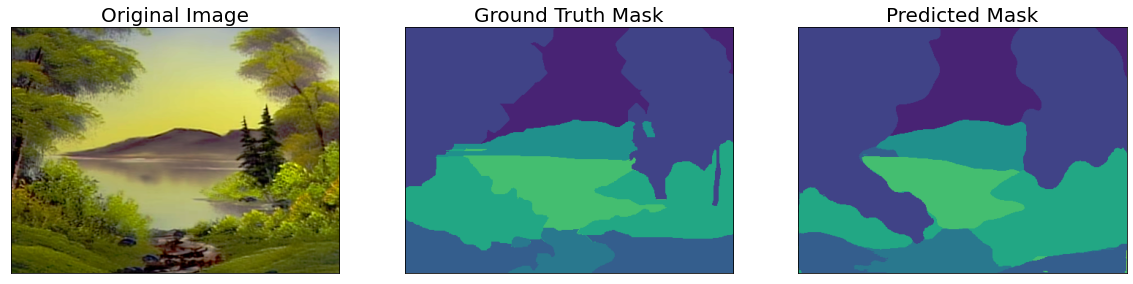

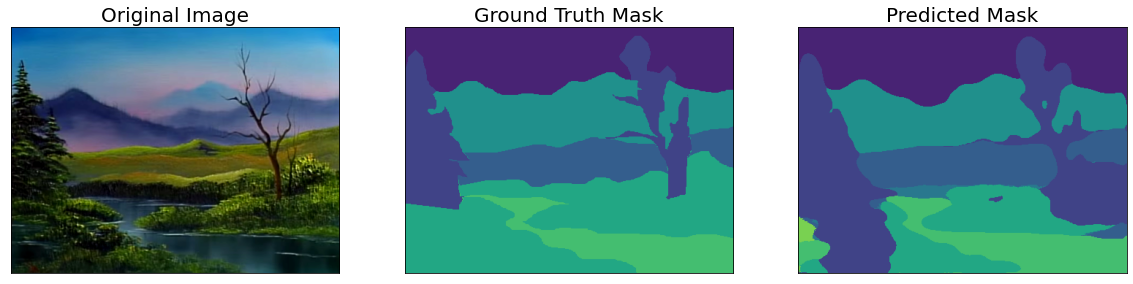

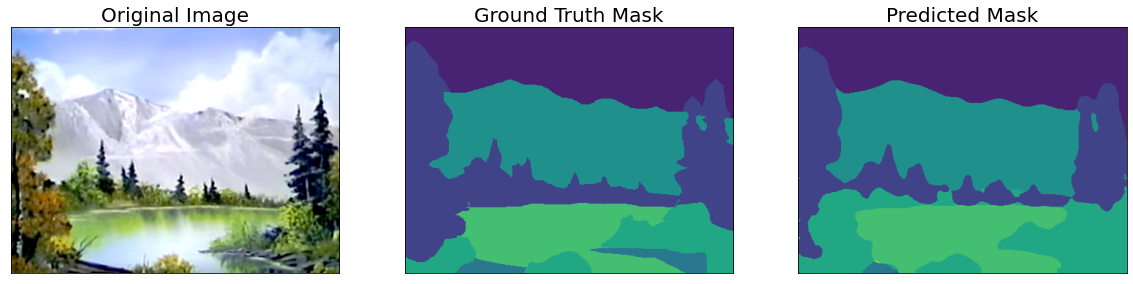

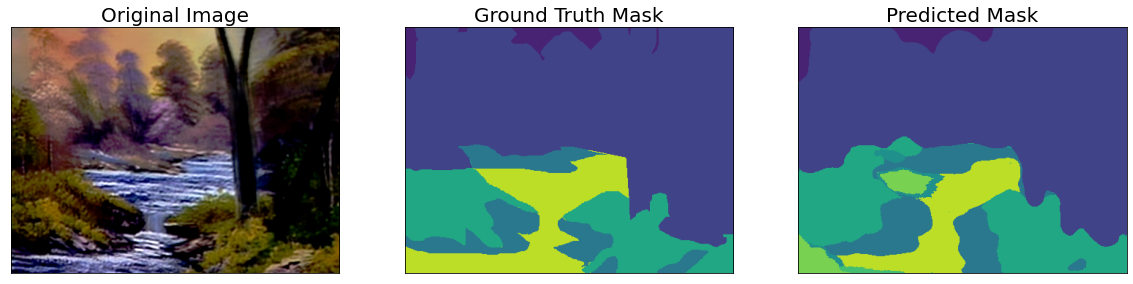

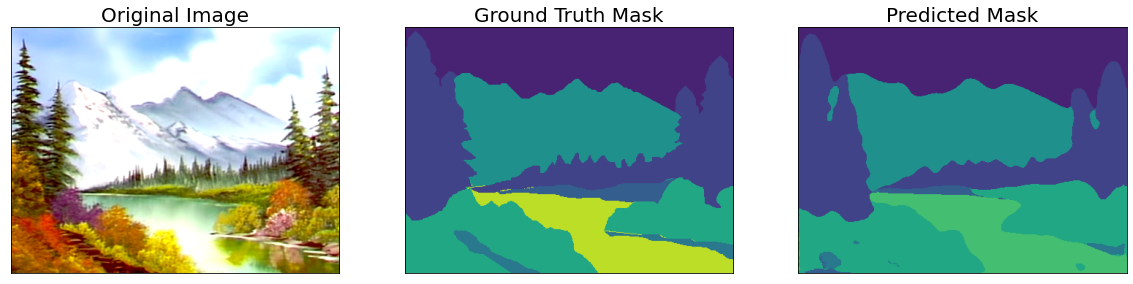

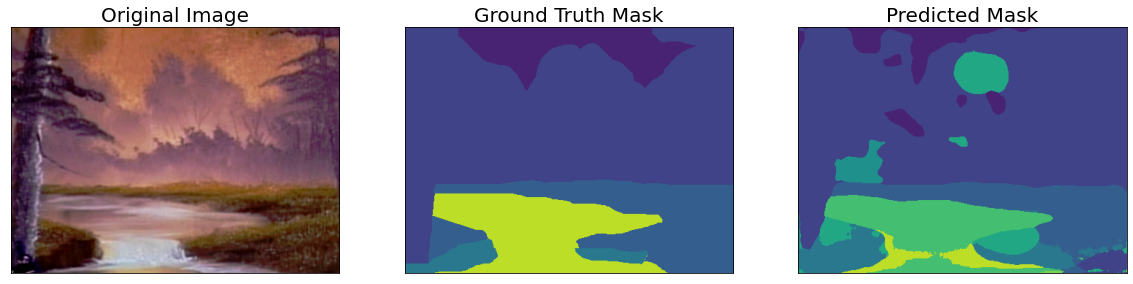

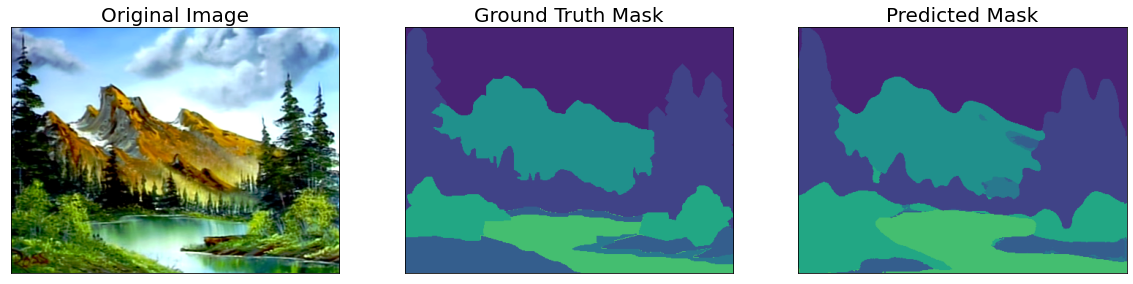

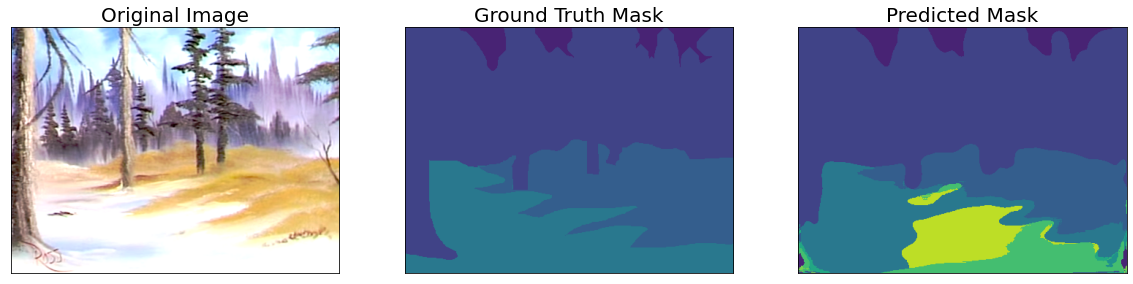

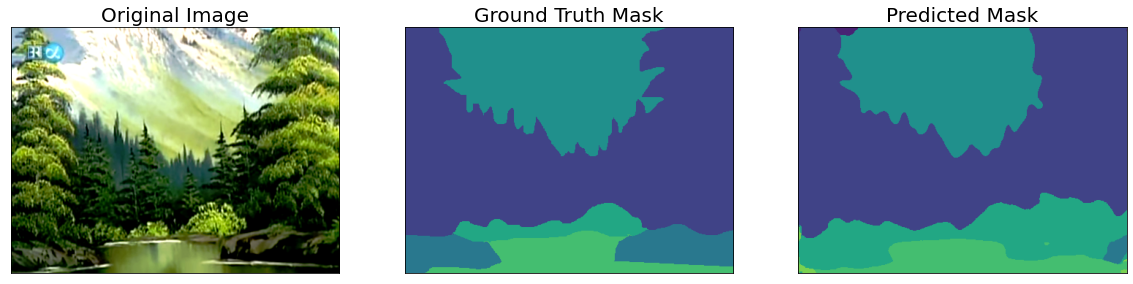

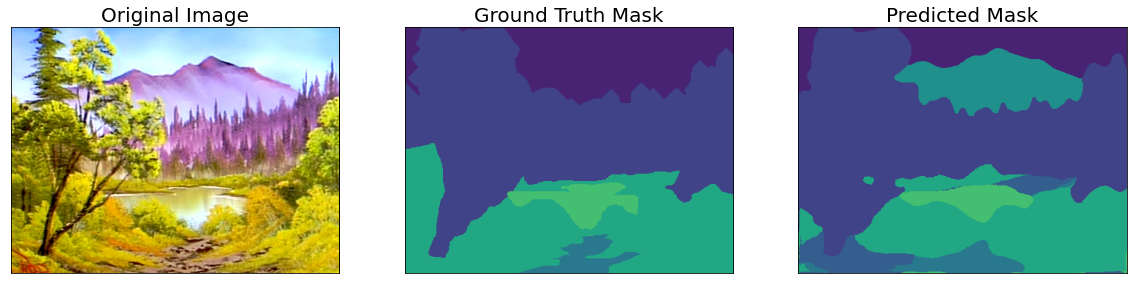

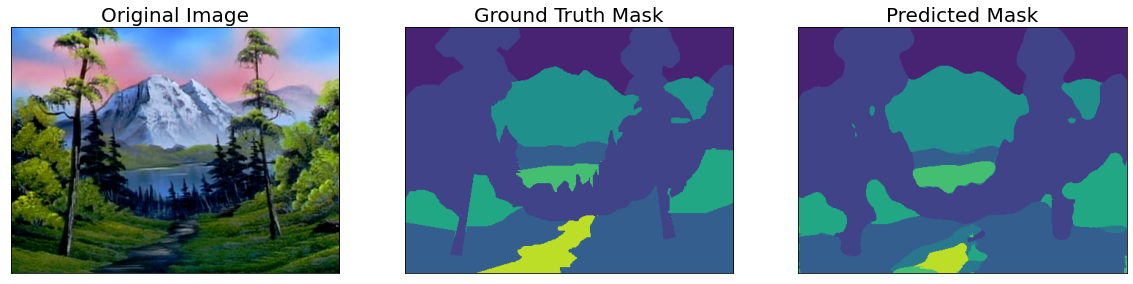

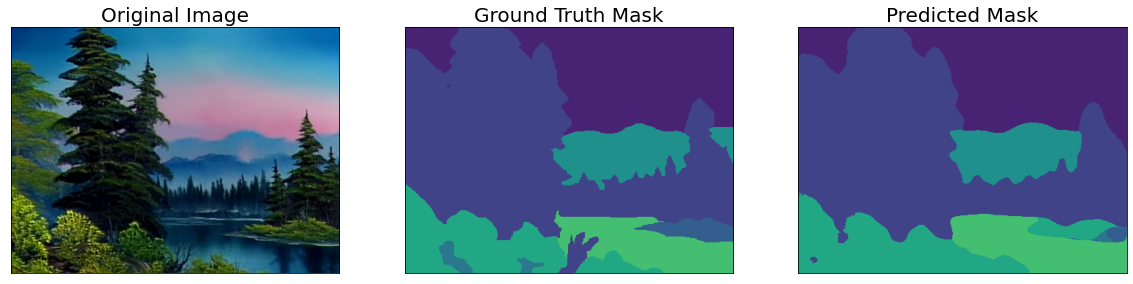

In [91]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    true_dimensions = image_vis.shape
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), color_palette), true_dimensions)['image']
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), color_palette), true_dimensions)['image']
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
    )

Model Evaluation on Test Dataset

In [92]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s, dice_loss - 0.4048, iou_score - 0.6406]
Evaluation on Test Data: 
Mean IoU Score: 0.6406
Mean Dice Loss: 0.4048


Plot Dice Loss & IoU Metric for Train vs. Val

In [93]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1         2         3         4         5   \
dice_loss  0.517104  0.512532  0.498321  0.494502  0.472369  0.477994   
iou_score  0.552616  0.597241  0.629154  0.628977  0.661250  0.637660   

                 6         7         8         9         10        11  \
dice_loss  0.459575  0.453085  0.445896  0.435292  0.425056  0.417370   
iou_score  0.664746  0.656840  0.663836  0.673125  0.692924  0.701512   

                 12        13        14        15        16        17  \
dice_loss  0.408372  0.386913  0.383401  0.381722  0.378451  0.351254   
iou_score  0.720220  0.742997  0.741153  0.734260  0.731178  0.765458   

                 18        19  
dice_loss  0.347930  0.335528  
iou_score  0.761087  0.768043

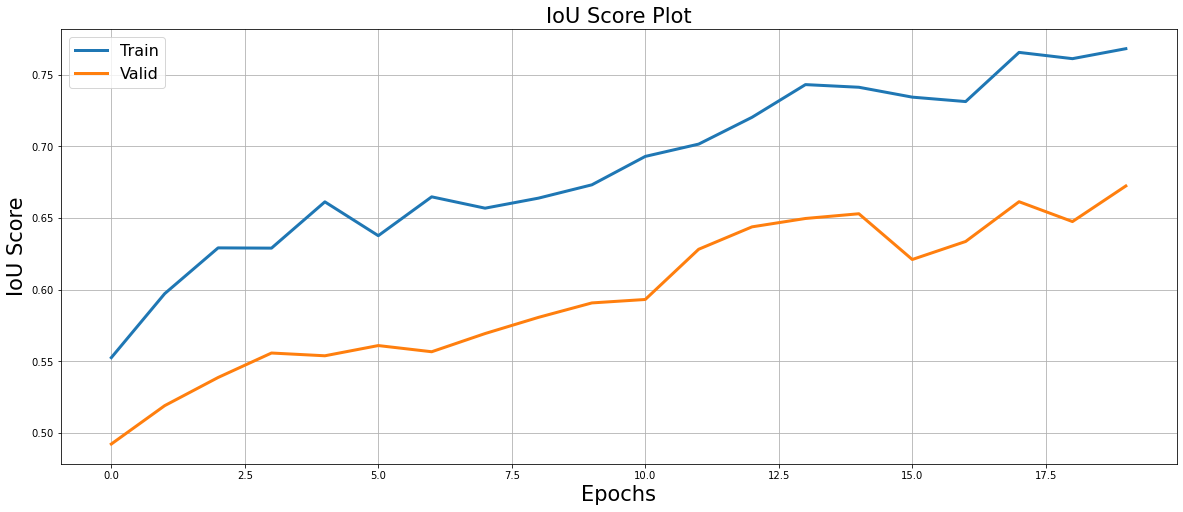

In [94]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

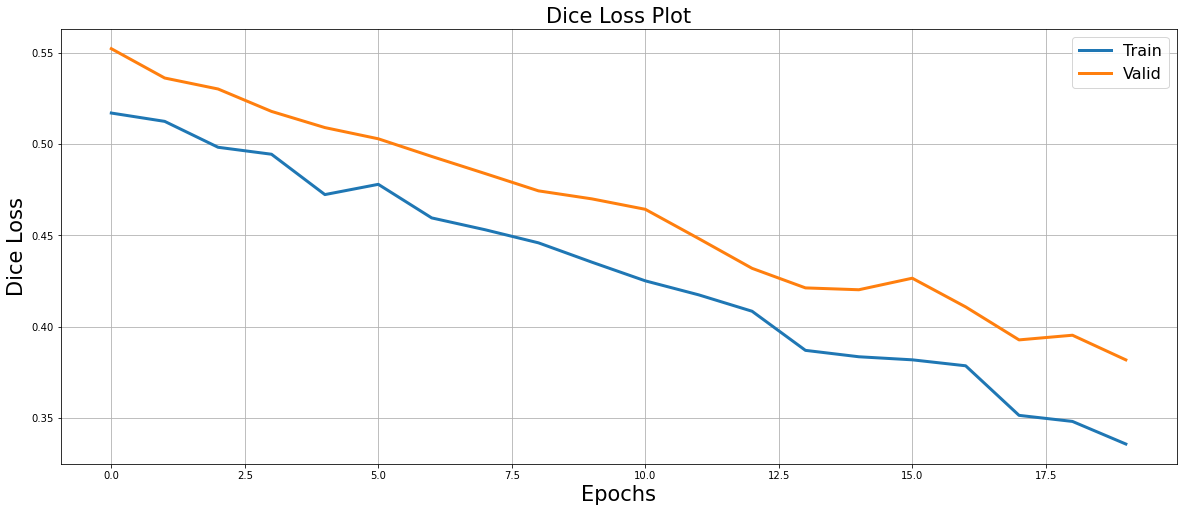

In [95]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Loss', fontsize=21)
plt.title('Dice Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

Comment: Model could be trained longer for better performance